In [3]:
from Model import Model
import pandas as pd
import numpy as np
import itertools
import shap
from sklearn.model_selection import train_test_split

In [4]:
model = Model('ranf')

In [8]:
X,Y = model.preprocessing.load_data('../Agg_data_from_frame_294.xlsx',labels=False,sheet_name="Sheet1")
Y_old = model.preprocessing.load_Y('../Updated_targets_300519.xlsx',video_name=False)
Y_new = model.preprocessing.load_Y('../../Frame_Analysis/new_targets.xlsx',video_name=False)

In [12]:
X = X.set_index(X['Video Name'])
X = X.drop('Unnamed: 0',1)
Y_old['Video Name'] = Y_old.index.values
Y_new['Video Name'] = Y_new.index.values

Y_new = Y_new[Y_new['Video Name']!= 'Surface Laptop_UK_30_Courtney v2 US VO_TV']
Y_new = Y_new[Y_new['Video Name']!='284 Surface Laptop_UK_30_Courtney v2 US VO_TV' ]
Y_new = Y_new.drop('Video Name',1)
Y = pd.concat((Y_old,Y_new),axis=1)
Y = Y.loc[X.index.values,:]

In [13]:
Y.dropna(how='all')
X,Y= model.preprocessing.clean_data(X,Y)

In [14]:
surface_pro_frames = [col for col in X.columns if "Surface Pro".lower() in col.lower()]
for suf in ['_dur','_first_ocr','_last_ocr','_total_ocr']:
    cols = [col+suf for col in surface_pro_frames[:10]]
    X = model.preprocessing.addNewFeature(X,cols,_type="sum",new_column_name="Surface"+suf)
X = X.drop(surface_pro_frames,axis=1)

In [15]:
frame_count_columns = [col for col in X.columns.values if '_dur' in col]
columns_removed =[]
for x in X.columns.values:
    if '_frame_count' in x:
        columns_removed.append(x)
cols = [col[:-12] for col in columns_removed]
for x in frame_count_columns:
#     if x+'_dur' in X.columns.values or '_frame_count' in x:
    if x[:-4] not in cols:
        columns_removed.append(x[:-4])
columns_removed.remove('Intel')
columns_removed.remove('Surface')

In [16]:
X = X.drop(columns=columns_removed,axis=1)
columns_removed

['Female_frame_count',
 'Male_frame_count',
 'Age: 5-15_frame_count',
 'Age: 0-5_frame_count',
 'Age: 15-24_frame_count',
 'Age: 25-34_frame_count',
 'Age: 35-44_frame_count',
 'Age: 45-60_frame_count',
 'Angry_frame_count',
 'Disgust_frame_count',
 'Fear_frame_count',
 'Happiness_frame_count',
 'Neutral_frame_count',
 'Sadness_frame_count',
 'Surprise_frame_count',
 'African_frame_count',
 'Caucasian_frame_count',
 'Eastasian_frame_count',
 'Latino_frame_count',
 'microsoft',
 'ASUS T102',
 'Dell PCs',
 'Dell XPS',
 'Dell XPS 13',
 'HP Spectre x360',
 'HP Spectre x360, Windows',
 'Lenovo PCs',
 'Lenovo Yoga 720',
 'Lenovo Yoga 910',
 'MacBook Air',
 'MacBook Pro',
 'Macbook Air',
 'Microsoft Surface',
 'Suface Laptop',
 'Surface Book',
 'Surface Go',
 'Surface Laptop',
 'Surface Pen',
 'Surface laptop',
 'The surface Laptop',
 'Windows',
 'Windows 10',
 'Windows 10 PC',
 'Windows 10 PCs',
 'Windows 10, HP_Spectre',
 'Windows 10, Windows',
 'Yoga',
 'Laptop',
 'Tablet',
 'Mobile',
 'PC']

In [17]:
new_features =[["Happiness_dur",'Female_dur'],["Surprise_dur","Male_dur"],["Neutral_dur","Male_dur"],["Happiness_dur","Age: 0-5_dur"],["Disgust_dur","Age: 45-60_dur"],["Surprise_dur","Age: 0-5_dur"],["Neutral_dur","Age: 25-34_dur"],["Happiness_dur","Eastasian_dur"],["Surprise_dur","Eastasian_dur"]]
age_cols = ['Age: 5-15_dur', 'Age: 0-5_dur', 'Age: 15-24_dur','Age: 25-34_dur', 'Age: 35-44_dur', 'Age: 45-60_dur']
ethinicity_cols = ['African_dur', 'Caucasian_dur', 'Eastasian_dur','Latino_dur']
age_ethinicity_col = list(itertools.product(age_cols,ethinicity_cols))
new_features.extend(age_ethinicity_col)
X = model.preprocessing.addNewFeature(X,new_features,_type='per')
X['Happiness_length_of_ad_impact'] = X['Happiness_dur'] * (1-X['length_of_ad_15'])

In [18]:
model.preprocessing.checkNull(X).head()
X= model.preprocessing.removeNULLColumns(X,percentage=0.8)
model.preprocessing.checkNull(X).head()

Age: 35-44_dur            76.146789
Windows 10_first_ocr      71.559633
Windows 10_last_ocr       71.559633
Windows 10_total_ocr      71.559633
Age: 25-34_African_dur    71.559633
dtype: float64

In [19]:
ocr_columns = [col for col in X.columns if "ocr" in col]

X[ocr_columns] = model.preprocessing.imputeConstant(X,columns=ocr_columns,constant=-1)
X = model.preprocessing.replace(X,np.inf,np.nan)

In [20]:
X = model.preprocessing.imputeConstant(X,constant=0)
X = X.fillna(0)

In [21]:
# Y = model.preprocessing.imputeMedian(Y,model.preprocessing.targets)
Y.isna().sum()

Unaided_Branding                    43
Brand_Cues__Mean                     0
Aided_Branding__Mean                 0
Active_Involvement__Mean             0
New_Information__Mean                0
Enjoyment__Mean                      0
Brand_Appeal__Mean                   0
Understanding__Mean                  0
Relevance_of_Information__Mean       0
Credibility_of_Information__Mean     0
Brand_Difference__Mean               0
Video Name                           0
Interest_peak                       42
Interest_mean_score                 42
Purchase_intent                      0
Persuasion_mean                      0
Persuasion_very_likely               0
Interest_peak_frames                42
dtype: int64

In [22]:
len(X.columns.values)

67

In [23]:
Y_14 = Y.loc[:,Y.isna().sum()==0]
Y_4 = Y.loc[:,Y.isna().sum()!=0]
X_4 = X[Y_4['Unaided_Branding'].isna()==False]
Y_4 = Y_4[Y_4['Unaided_Branding'].isna()==False]

In [16]:
X_res_14,Y_res_14 = model.preprocessing.overSampling(X,Y_14,each_Col=False,size=1000,random_state=12)
X_train_14,X_test_14,y_train_14,y_test_14 = train_test_split(X_res_14,Y_res_14,random_state = 123,test_size=0.3)

X_res_4,Y_res_4 = model.preprocessing.overSampling(X_4,Y_4,each_Col=False,size=1000,random_state=12)
X_train_4,X_test_4,y_train_4,y_test_4 = train_test_split(X_res_4,Y_res_4,random_state = 123,test_size=0.3)

In [17]:
print("------------------------ 14 Models Training ----------------------------\n")
models_14 = model.train(X_train_14,y_train_14.drop('Video Name',1),X_test_14,y_test_14.drop('Video Name',1),metrics='r2',plot_error=False)
print("------------------------ 4 Models Training ----------------------------\n")
models_4 = model.train(X_train_4,y_train_4,X_test_4,y_test_4,metrics='r2',plot_error=False)

------------------------ 14 Models Training ----------------------------

Brand_Cues__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.907303
For test set
r2_score: 0.933388


Aided_Branding__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.903463
For test set
r2_score: 0.938270


Active_Involvement__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.914487
For test set
r2_score: 0.960959


New_Information__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.933089
For test set
r2_score: 0.957202


Enjoyment__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.924001
For test set
r2_score: 0.951779


Brand_Appeal__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.939119
For test set
r2_score: 0.962102


Understanding__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.876389
For test set
r2_score: 0.909178


Relevance_of_Information__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.925560
For test set
r2_score: 0.936113


Credibility_of_Information__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.897429
For test set
r2_score: 0.929704


Brand_Difference__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.918180
For test set
r2_score: 0.945678


Purchase_intent


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.953112
For test set
r2_score: 0.953923


Persuasion_mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.862931
For test set
r2_score: 0.931300


Persuasion_very_likely


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.906612
For test set
r2_score: 0.945425


------------------------ 4 Models Training ----------------------------

Unaided_Branding


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.963116
For test set
r2_score: 0.967367


Interest_peak


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.911143
For test set
r2_score: 0.917513


Interest_mean_score


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.951225
For test set
r2_score: 0.959818


Interest_peak_frames


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


For training set
r2_score: 0.916388
For test set
r2_score: 0.921648




[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


Brand_Cues__Mean
Feature ranking:
ASUS T102_dur
Laptop_last_ocr
microsoft_last_ocr
microsoft_first_ocr
Dell XPS 13_dur
Neutral_dur
microsoft_dur
Windows 10_last_ocr
Windows 10_first_ocr
microsoft_total_ocr
Laptop_first_ocr
Laptop_dur
African_dur
Windows 10_dur
Neutral_Age: 25-34_dur
Happiness_length_of_ad_impact
Caucasian_dur
Laptop_total_ocr
Age: 25-34_dur
Male_dur
Age: 25-34_African_dur
Windows 10_total_ocr
Happiness_Female_dur
Age: 25-34_Eastasian_dur
Happiness_dur
Female_dur
Tablet_total_ocr
Surface Go_dur
length_of_ad_15
Age: 35-44_dur
Age: 25-34_Caucasian_dur
Tablet_first_ocr
Tablet_last_ocr
Eastasian_dur
Sadness_dur
Tablet_dur
Surface_first_ocr
Happiness_Eastasian_dur
Neutral_Male_dur
Surface_last_ocr
Surface Book_dur
Surface_dur
Surface laptop_dur
Surface_total_ocr
Windows_dur
Windows 10 PCs_dur
Dell PCs_dur
Surface Pen_dur
Surface Laptop_dur
Microsoft Surface_dur
Lenovo Yoga 910_dur
Lenovo Yoga 720_dur
HP Spectre x360_dur
HP Spectre x360, Windows_dur
Windows 10, Windows_dur
ad

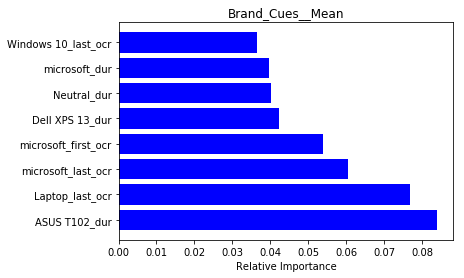

Aided_Branding__Mean
Feature ranking:
microsoft_last_ocr
ASUS T102_dur
Laptop_total_ocr
Windows 10_last_ocr
microsoft_first_ocr
Windows 10_first_ocr
Windows 10_dur
Surface Go_dur
Happiness_Female_dur
Male_dur
Neutral_dur
microsoft_dur
Windows 10_total_ocr
Laptop_last_ocr
Eastasian_dur
microsoft_total_ocr
Laptop_dur
Age: 25-34_dur
Happiness_dur
HP Spectre x360, Windows_dur
Neutral_Age: 25-34_dur
Dell XPS 13_dur
Laptop_first_ocr
Age: 25-34_African_dur
Tablet_total_ocr
Female_dur
African_dur
Tablet_last_ocr
Happiness_length_of_ad_impact
Sadness_dur
Surface laptop_dur
Caucasian_dur
Tablet_first_ocr
Tablet_dur
Happiness_Eastasian_dur
Age: 25-34_Eastasian_dur
Neutral_Male_dur
Age: 35-44_dur
Windows 10 PCs_dur
Lenovo Yoga 910_dur
Age: 25-34_Caucasian_dur
Surface_first_ocr
Microsoft Surface_dur
Surface_dur
Surface Book_dur
ad_type_tv
Surface_total_ocr
Windows 10, HP_Spectre_dur
Windows_dur
length_of_ad_15
Surface_last_ocr
Surface Laptop_dur
Lenovo Yoga 720_dur
Windows 10, Windows_dur
Surface P

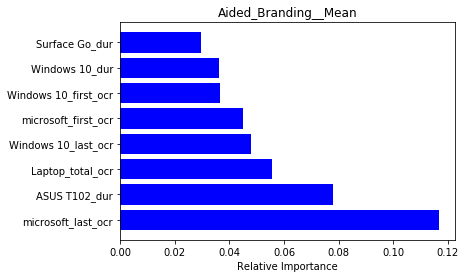

Active_Involvement__Mean
Feature ranking:
Tablet_last_ocr
Tablet_total_ocr
Caucasian_dur
Laptop_last_ocr
microsoft_first_ocr
Laptop_dur
Laptop_total_ocr
Tablet_dur
microsoft_dur
microsoft_last_ocr
microsoft_total_ocr
Age: 25-34_Caucasian_dur
Neutral_Male_dur
The surface Laptop_dur
Laptop_first_ocr
Neutral_dur
Windows 10 PCs_dur
African_dur
length_of_ad_15
Age: 25-34_dur
Age: 25-34_African_dur
Female_dur
Neutral_Age: 25-34_dur
Windows 10_first_ocr
Windows 10_dur
Tablet_first_ocr
Eastasian_dur
Male_dur
Dell PCs_dur
Happiness_dur
Happiness_Eastasian_dur
Surface laptop_dur
Age: 25-34_Eastasian_dur
Happiness_Female_dur
Windows 10_total_ocr
Windows 10_last_ocr
Happiness_length_of_ad_impact
Sadness_dur
Surface_last_ocr
Surface_first_ocr
Surface_dur
Age: 35-44_dur
Surface Go_dur
Windows 10, HP_Spectre_dur
Surface_total_ocr
Surface Book_dur
Windows_dur
HP Spectre x360, Windows_dur
Surface Laptop_dur
Windows 10, Windows_dur
ad_type_tv
MacBook Pro_dur
Macbook Air_dur
Lenovo Yoga 910_dur
HP Spectr

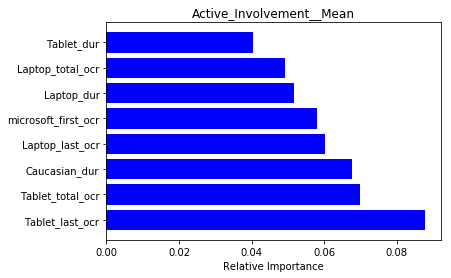

New_Information__Mean
Feature ranking:
Windows 10_dur
Windows 10_total_ocr
Windows 10_last_ocr
microsoft_last_ocr
Laptop_last_ocr
Tablet_first_ocr
Tablet_last_ocr
Windows 10_first_ocr
Age: 25-34_African_dur
Laptop_total_ocr
African_dur
Age: 25-34_Caucasian_dur
Tablet_total_ocr
microsoft_total_ocr
microsoft_first_ocr
Laptop_dur
Neutral_dur
Caucasian_dur
Male_dur
Windows 10, Windows_dur
Surface Go_dur
Age: 25-34_Eastasian_dur
Happiness_Female_dur
Age: 25-34_dur
Dell XPS 13_dur
Female_dur
Laptop_first_ocr
Happiness_Eastasian_dur
Windows_dur
microsoft_dur
HP Spectre x360, Windows_dur
Surface_total_ocr
Happiness_dur
Tablet_dur
Neutral_Age: 25-34_dur
Neutral_Male_dur
Surface_dur
length_of_ad_15
Eastasian_dur
Surface_last_ocr
Age: 35-44_dur
Windows 10 PCs_dur
Sadness_dur
Lenovo Yoga 910_dur
Surface_first_ocr
Happiness_length_of_ad_impact
Dell PCs_dur
Surface Book_dur
ASUS T102_dur
Surface Laptop_dur
Microsoft Surface_dur
Surface laptop_dur
Suface Laptop_dur
MacBook Air_dur
HP Spectre x360_dur

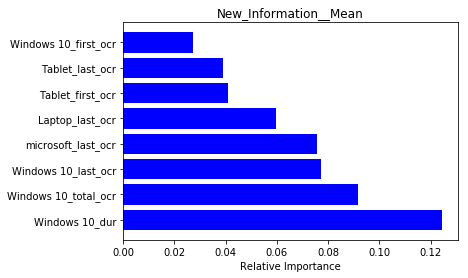

Enjoyment__Mean
Feature ranking:
microsoft_last_ocr
length_of_ad_15
Laptop_last_ocr
Happiness_length_of_ad_impact
Neutral_dur
Laptop_total_ocr
Windows 10_dur
Windows 10_total_ocr
Neutral_Age: 25-34_dur
Laptop_dur
Surface_first_ocr
Windows 10_first_ocr
Tablet_first_ocr
Surface_last_ocr
Windows 10_last_ocr
Age: 25-34_African_dur
Surface_total_ocr
Age: 25-34_dur
microsoft_first_ocr
Tablet_last_ocr
Happiness_dur
African_dur
microsoft_total_ocr
Surface_dur
microsoft_dur
Neutral_Male_dur
Happiness_Eastasian_dur
Laptop_first_ocr
Tablet_dur
Happiness_Female_dur
Female_dur
Sadness_dur
Male_dur
Caucasian_dur
Surface Book_dur
Tablet_total_ocr
Age: 25-34_Eastasian_dur
Windows 10 PCs_dur
Age: 25-34_Caucasian_dur
Eastasian_dur
Age: 35-44_dur
Windows_dur
HP Spectre x360, Windows_dur
Windows 10, Windows_dur
Dell PCs_dur
Surface Go_dur
ASUS T102_dur
The surface Laptop_dur
Lenovo Yoga 910_dur
Surface Laptop_dur
Surface laptop_dur
Dell XPS 13_dur
Yoga_dur
HP Spectre x360_dur
Macbook Air_dur
Surface Pen_d

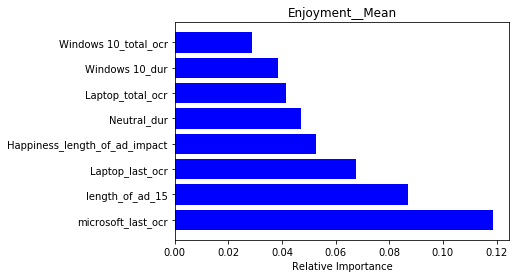

Brand_Appeal__Mean
Feature ranking:
Windows 10_last_ocr
Windows 10_first_ocr
Windows 10_dur
Windows 10_total_ocr
microsoft_last_ocr
African_dur
Laptop_last_ocr
Age: 25-34_African_dur
length_of_ad_15
microsoft_first_ocr
Laptop_total_ocr
Neutral_dur
Happiness_length_of_ad_impact
Male_dur
Female_dur
HP Spectre x360, Windows_dur
Age: 25-34_Eastasian_dur
Age: 25-34_dur
Neutral_Age: 25-34_dur
ASUS T102_dur
microsoft_total_ocr
Tablet_last_ocr
Happiness_Female_dur
Happiness_Eastasian_dur
Laptop_dur
Windows 10, Windows_dur
Happiness_dur
Laptop_first_ocr
microsoft_dur
Sadness_dur
Surface_dur
Surface laptop_dur
Surface_total_ocr
Surface_last_ocr
Windows_dur
Tablet_first_ocr
Caucasian_dur
Age: 25-34_Caucasian_dur
Tablet_dur
Neutral_Male_dur
Surface_first_ocr
Eastasian_dur
The surface Laptop_dur
Tablet_total_ocr
Windows 10 PCs_dur
Age: 35-44_dur
Dell PCs_dur
Surface Go_dur
Lenovo Yoga 910_dur
Yoga_dur
Surface Laptop_dur
Microsoft Surface_dur
Surface Book_dur
Lenovo Yoga 720_dur
Dell XPS 13_dur
ad_t

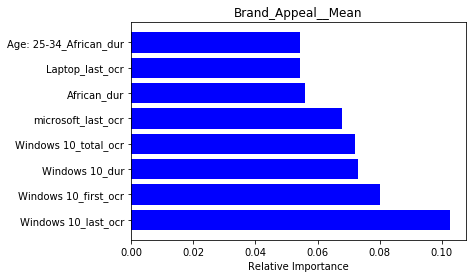

Understanding__Mean
Feature ranking:
microsoft_last_ocr
microsoft_dur
Happiness_Female_dur
Windows 10, Windows_dur
Laptop_last_ocr
HP Spectre x360, Windows_dur
African_dur
Laptop_first_ocr
microsoft_first_ocr
microsoft_total_ocr
Windows_dur
Female_dur
Lenovo Yoga 910_dur
Neutral_dur
Windows 10_first_ocr
Laptop_dur
Age: 25-34_dur
Windows 10_last_ocr
Tablet_dur
Age: 25-34_Caucasian_dur
Caucasian_dur
Male_dur
Neutral_Age: 25-34_dur
Age: 25-34_Eastasian_dur
Laptop_total_ocr
Dell XPS 13_dur
Eastasian_dur
Sadness_dur
ASUS T102_dur
Tablet_last_ocr
Age: 25-34_African_dur
Happiness_dur
Tablet_total_ocr
Surface Go_dur
Tablet_first_ocr
Windows 10_dur
Neutral_Male_dur
Happiness_length_of_ad_impact
Happiness_Eastasian_dur
Age: 35-44_dur
Windows 10 PCs_dur
Windows 10_total_ocr
Surface_dur
Surface_last_ocr
Surface_first_ocr
Surface_total_ocr
Surface Book_dur
Surface laptop_dur
Surface Laptop_dur
Dell PCs_dur
Surface Pen_dur
length_of_ad_15
ad_type_tv
Microsoft Surface_dur
MacBook Air_dur
Yoga_dur
Len

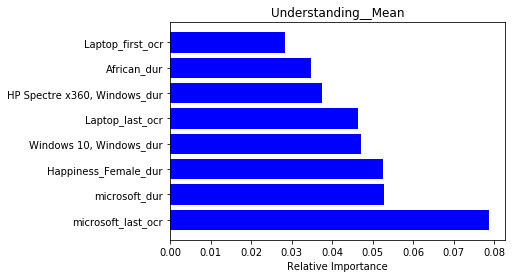

Relevance_of_Information__Mean
Feature ranking:
microsoft_last_ocr
Laptop_total_ocr
length_of_ad_15
ASUS T102_dur
Laptop_last_ocr
microsoft_total_ocr
Tablet_total_ocr
microsoft_first_ocr
Neutral_dur
Tablet_last_ocr
Age: 25-34_dur
Surface Go_dur
microsoft_dur
Tablet_first_ocr
Happiness_dur
Windows 10_last_ocr
Age: 25-34_African_dur
Windows 10_dur
Neutral_Age: 25-34_dur
Tablet_dur
Female_dur
Laptop_dur
Laptop_first_ocr
Caucasian_dur
Male_dur
Windows 10_total_ocr
Happiness_length_of_ad_impact
Neutral_Male_dur
Windows 10_first_ocr
African_dur
Surface Pen_dur
Age: 25-34_Eastasian_dur
Age: 25-34_Caucasian_dur
Age: 35-44_dur
Happiness_Eastasian_dur
Eastasian_dur
Sadness_dur
Happiness_Female_dur
Surface Book_dur
Surface_first_ocr
Windows 10 PCs_dur
Surface_dur
Surface_total_ocr
Surface Laptop_dur
Surface_last_ocr
Surface laptop_dur
Dell PCs_dur
Windows_dur
The surface Laptop_dur
Lenovo Yoga 720_dur
Microsoft Surface_dur
Windows 10, Windows_dur
ad_type_tv
Macbook Air_dur
HP Spectre x360_dur
HP 

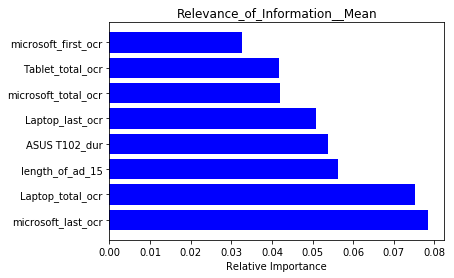

Credibility_of_Information__Mean
Feature ranking:
Laptop_last_ocr
microsoft_last_ocr
microsoft_total_ocr
Windows 10_last_ocr
Windows 10_total_ocr
microsoft_dur
Windows 10_dur
HP Spectre x360, Windows_dur
Windows 10 PCs_dur
Windows 10, Windows_dur
Windows 10_first_ocr
Laptop_total_ocr
Laptop_first_ocr
microsoft_first_ocr
Surface Go_dur
Male_dur
Neutral_dur
Laptop_dur
Tablet_total_ocr
Surface_first_ocr
Tablet_last_ocr
Happiness_dur
Female_dur
Happiness_Female_dur
African_dur
Eastasian_dur
Age: 25-34_Caucasian_dur
Caucasian_dur
Neutral_Age: 25-34_dur
Surface Book_dur
Age: 25-34_dur
Happiness_length_of_ad_impact
Neutral_Male_dur
Tablet_first_ocr
Age: 25-34_Eastasian_dur
Happiness_Eastasian_dur
Surface_dur
Age: 25-34_African_dur
Windows_dur
Surface Pen_dur
Surface_last_ocr
Sadness_dur
Tablet_dur
Dell PCs_dur
length_of_ad_15
Surface_total_ocr
Dell XPS 13_dur
Surface laptop_dur
Age: 35-44_dur
Lenovo Yoga 720_dur
ad_type_tv
Microsoft Surface_dur
MacBook Pro_dur
MacBook Air_dur
Surface Laptop_d

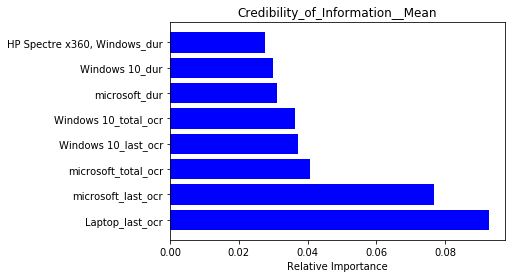

Brand_Difference__Mean
Feature ranking:
microsoft_last_ocr
Laptop_last_ocr
length_of_ad_15
Windows 10_last_ocr
Windows 10_first_ocr
Windows 10_dur
Tablet_first_ocr
Windows 10_total_ocr
microsoft_first_ocr
Tablet_last_ocr
microsoft_total_ocr
Happiness_length_of_ad_impact
Tablet_total_ocr
Windows 10 PCs_dur
Age: 25-34_African_dur
Laptop_first_ocr
Dell XPS 13_dur
Age: 25-34_dur
Laptop_total_ocr
Neutral_Male_dur
Laptop_dur
Happiness_dur
Neutral_dur
Age: 25-34_Eastasian_dur
African_dur
Caucasian_dur
Neutral_Age: 25-34_dur
microsoft_dur
Tablet_dur
Happiness_Eastasian_dur
Eastasian_dur
Sadness_dur
ASUS T102_dur
Dell PCs_dur
Windows 10, Windows_dur
HP Spectre x360, Windows_dur
Happiness_Female_dur
Windows_dur
Male_dur
Female_dur
Surface_first_ocr
Surface_dur
Age: 25-34_Caucasian_dur
Surface_total_ocr
Microsoft Surface_dur
Age: 35-44_dur
Surface_last_ocr
Surface laptop_dur
HP Spectre x360_dur
Surface Go_dur
Surface Book_dur
Surface Laptop_dur
Lenovo Yoga 720_dur
MacBook Air_dur
ad_type_tv
Windo

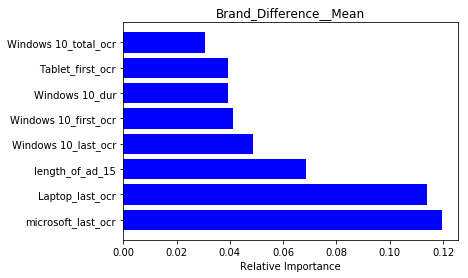

Purchase_intent
Feature ranking:
microsoft_first_ocr
Tablet_dur
Surface_dur
Surface Book_dur
microsoft_total_ocr
Surface_first_ocr
Surface_last_ocr
Laptop_last_ocr
Tablet_total_ocr
Surface_total_ocr
Surface Go_dur
Tablet_last_ocr
Laptop_first_ocr
Surface laptop_dur
Laptop_dur
Laptop_total_ocr
Tablet_first_ocr
Caucasian_dur
Windows 10_last_ocr
Windows 10 PCs_dur
Windows 10_dur
Happiness_dur
Surface Laptop_dur
Windows 10_first_ocr
Neutral_Male_dur
microsoft_dur
Age: 25-34_dur
microsoft_last_ocr
Windows 10_total_ocr
Happiness_length_of_ad_impact
Age: 35-44_dur
Age: 25-34_Eastasian_dur
Sadness_dur
African_dur
Neutral_Age: 25-34_dur
Neutral_dur
Age: 25-34_Caucasian_dur
Female_dur
Happiness_Female_dur
Dell PCs_dur
Male_dur
Eastasian_dur
Age: 25-34_African_dur
Windows 10, Windows_dur
Happiness_Eastasian_dur
length_of_ad_15
Lenovo Yoga 720_dur
HP Spectre x360, Windows_dur
Windows 10, HP_Spectre_dur
HP Spectre x360_dur
Windows_dur
Windows 10 PC_dur
MacBook Air_dur
Dell XPS 13_dur
Surface Pen_du

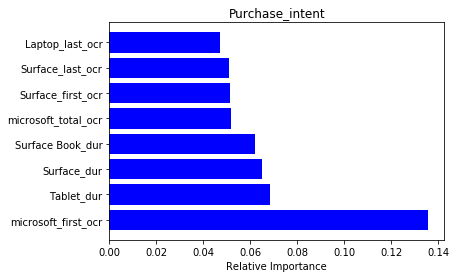

Persuasion_mean
Feature ranking:
microsoft_first_ocr
Laptop_dur
microsoft_total_ocr
Age: 25-34_Eastasian_dur
Lenovo Yoga 720_dur
Neutral_Age: 25-34_dur
Windows 10 PCs_dur
Age: 25-34_dur
Neutral_dur
Laptop_last_ocr
Tablet_first_ocr
Laptop_first_ocr
Laptop_total_ocr
microsoft_dur
Age: 25-34_Caucasian_dur
Caucasian_dur
Surface laptop_dur
Happiness_Female_dur
Neutral_Male_dur
Eastasian_dur
Tablet_total_ocr
Tablet_last_ocr
Happiness_length_of_ad_impact
Female_dur
microsoft_last_ocr
Tablet_dur
Happiness_Eastasian_dur
Windows 10, Windows_dur
Happiness_dur
Male_dur
Surface_last_ocr
length_of_ad_15
Windows 10_first_ocr
Windows_dur
Windows 10_total_ocr
Sadness_dur
HP Spectre x360, Windows_dur
Age: 25-34_African_dur
Windows 10_last_ocr
African_dur
Age: 35-44_dur
Windows 10_dur
Surface_first_ocr
Surface_dur
Surface Book_dur
Dell PCs_dur
MacBook Air_dur
The surface Laptop_dur
Windows 10 PC_dur
Surface Go_dur
ASUS T102_dur
HP Spectre x360_dur
Surface_total_ocr
Surface Laptop_dur
Macbook Air_dur
Micr

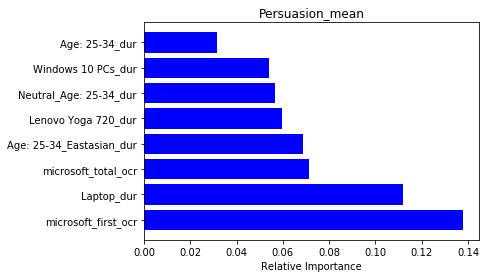

Persuasion_very_likely
Feature ranking:
microsoft_first_ocr
Caucasian_dur
Laptop_dur
Surface_dur
Age: 25-34_dur
microsoft_total_ocr
Age: 25-34_Caucasian_dur
Surface_first_ocr
Surface_last_ocr
Age: 25-34_Eastasian_dur
Surface_total_ocr
Neutral_dur
Surface laptop_dur
Neutral_Age: 25-34_dur
Tablet_last_ocr
Windows 10 PCs_dur
Laptop_last_ocr
Tablet_first_ocr
Laptop_total_ocr
Surface Book_dur
microsoft_dur
Female_dur
Tablet_total_ocr
Windows 10_dur
Tablet_dur
Happiness_dur
Windows 10_last_ocr
Laptop_first_ocr
Lenovo Yoga 720_dur
Windows 10_total_ocr
Surface Go_dur
Happiness_Female_dur
Neutral_Male_dur
Windows 10_first_ocr
Male_dur
Happiness_Eastasian_dur
microsoft_last_ocr
African_dur
Windows 10, Windows_dur
Sadness_dur
Happiness_length_of_ad_impact
Eastasian_dur
Age: 35-44_dur
HP Spectre x360, Windows_dur
Windows_dur
Age: 25-34_African_dur
Dell PCs_dur
HP Spectre x360_dur
Windows 10 PC_dur
The surface Laptop_dur
length_of_ad_15
Surface Laptop_dur
Surface Pen_dur
MacBook Air_dur
ad_type_tv


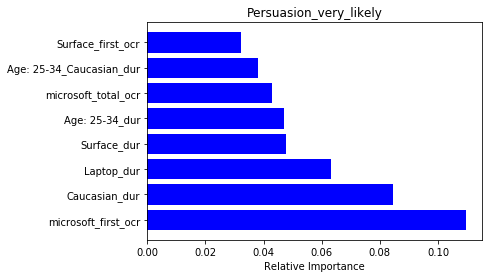

In [20]:
model.plot_feature_importance(models_14,10,y_train_14.drop('Video Name',1).columns,X_train_14.columns[1:],savefig=False)

Unaided_Branding
Feature ranking:
microsoft_first_ocr
Lenovo Yoga 910_dur
Windows 10_total_ocr
Windows 10_dur
Male_dur
Yoga_dur
ASUS T102_dur
Surface_last_ocr
ad_type_tv
Windows 10_first_ocr
Female_dur
Surface_total_ocr
microsoft_dur
Laptop_dur
Laptop_last_ocr
Laptop_first_ocr
Age: 25-34_Eastasian_dur
microsoft_last_ocr
Windows 10_last_ocr
Surface_dur
Laptop_total_ocr
Age: 25-34_African_dur
HP Spectre x360_dur
Happiness_Female_dur
Happiness_dur
Surface_first_ocr
Neutral_Age: 25-34_dur
Neutral_dur
Neutral_Male_dur
Caucasian_dur
Sadness_dur
African_dur
Dell XPS 13_dur
Age: 25-34_dur
Windows 10, HP_Spectre_dur
Eastasian_dur
Happiness_Eastasian_dur
HP Spectre x360, Windows_dur
Happiness_length_of_ad_impact
microsoft_total_ocr
Tablet_total_ocr
Tablet_first_ocr
Age: 25-34_Caucasian_dur
Tablet_last_ocr
length_of_ad_15
Tablet_dur
Windows 10, Windows_dur
Age: 35-44_dur
Windows_dur
Windows 10 PCs_dur
Surface Book_dur
Surface Pen_dur
Windows 10 PC_dur
MacBook Pro_dur
Macbook Air_dur
MacBook Air_d

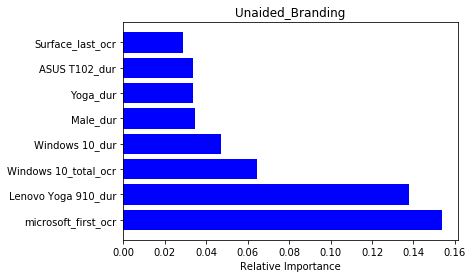

Interest_peak
Feature ranking:
Laptop_first_ocr
Windows 10 PC_dur
Neutral_Male_dur
Caucasian_dur
Neutral_Age: 25-34_dur
microsoft_last_ocr
Laptop_last_ocr
Age: 25-34_dur
Tablet_total_ocr
microsoft_first_ocr
Neutral_dur
Female_dur
Laptop_total_ocr
microsoft_dur
Eastasian_dur
Happiness_dur
Happiness_Female_dur
Surface_last_ocr
Laptop_dur
Age: 25-34_Caucasian_dur
Male_dur
Tablet_last_ocr
Sadness_dur
Macbook Air_dur
Surface_first_ocr
Windows 10_first_ocr
Tablet_dur
Happiness_Eastasian_dur
Windows 10_last_ocr
Happiness_length_of_ad_impact
Tablet_first_ocr
African_dur
Windows 10_dur
Age: 25-34_Eastasian_dur
Age: 35-44_dur
Windows 10 PCs_dur
microsoft_total_ocr
Surface Book_dur
Surface_dur
Age: 25-34_African_dur
Surface_total_ocr
HP Spectre x360_dur
Windows 10_total_ocr
ad_type_tv
length_of_ad_15
Lenovo Yoga 910_dur
MacBook Pro_dur
Windows_dur
HP Spectre x360, Windows_dur
Surface Pen_dur
ASUS T102_dur
Windows 10, HP_Spectre_dur
Windows 10, Windows_dur
Yoga_dur
Dell XPS 13_dur
MacBook Air_dur


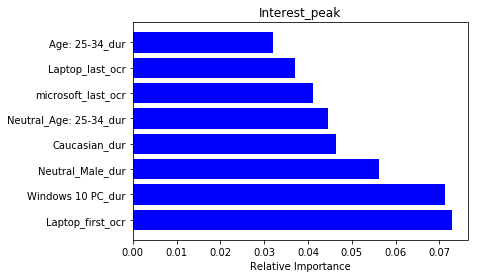

Interest_mean_score
Feature ranking:
Laptop_last_ocr
microsoft_last_ocr
Age: 25-34_dur
microsoft_first_ocr
length_of_ad_15
Neutral_dur
microsoft_dur
Windows_dur
Caucasian_dur
Eastasian_dur
Neutral_Age: 25-34_dur
Neutral_Male_dur
Windows 10, Windows_dur
Laptop_dur
Age: 35-44_dur
Happiness_length_of_ad_impact
Laptop_total_ocr
Happiness_dur
Age: 25-34_African_dur
Laptop_first_ocr
Windows 10, HP_Spectre_dur
HP Spectre x360, Windows_dur
Tablet_dur
Surface Book_dur
microsoft_total_ocr
African_dur
Tablet_last_ocr
Male_dur
Windows 10_first_ocr
Surface_first_ocr
Surface_last_ocr
Windows 10_last_ocr
Tablet_total_ocr
Female_dur
Age: 25-34_Caucasian_dur
Sadness_dur
Surface_dur
Tablet_first_ocr
Windows 10_dur
Happiness_Female_dur
Windows 10_total_ocr
Age: 25-34_Eastasian_dur
Surface_total_ocr
Happiness_Eastasian_dur
Macbook Air_dur
Lenovo Yoga 910_dur
ad_type_tv
Surface Pen_dur
Windows 10 PCs_dur
MacBook Air_dur
Windows 10 PC_dur
HP Spectre x360_dur
MacBook Pro_dur
ASUS T102_dur
Dell XPS 13_dur
Yog

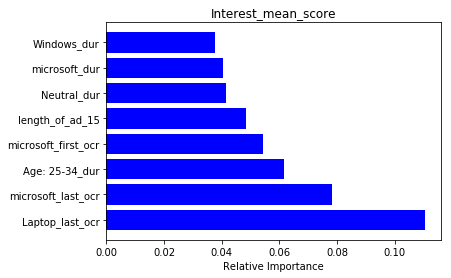

Interest_peak_frames
Feature ranking:
Windows 10 PC_dur
Laptop_first_ocr
Neutral_Male_dur
Caucasian_dur
Neutral_Age: 25-34_dur
microsoft_last_ocr
Laptop_last_ocr
Age: 25-34_dur
Tablet_total_ocr
microsoft_first_ocr
Neutral_dur
Laptop_total_ocr
Happiness_Female_dur
Female_dur
microsoft_dur
Happiness_dur
Laptop_dur
Eastasian_dur
Surface_last_ocr
Sadness_dur
Male_dur
Age: 25-34_Caucasian_dur
Macbook Air_dur
Happiness_Eastasian_dur
Windows 10_last_ocr
Tablet_last_ocr
Tablet_first_ocr
Tablet_dur
Windows 10_first_ocr
Surface_first_ocr
Happiness_length_of_ad_impact
African_dur
Windows 10 PCs_dur
Age: 25-34_Eastasian_dur
Windows 10_dur
microsoft_total_ocr
Age: 35-44_dur
Surface Book_dur
HP Spectre x360_dur
Age: 25-34_African_dur
Surface_dur
Surface_total_ocr
Windows 10_total_ocr
ad_type_tv
length_of_ad_15
Lenovo Yoga 910_dur
MacBook Pro_dur
Windows_dur
HP Spectre x360, Windows_dur
ASUS T102_dur
Surface Pen_dur
Windows 10, HP_Spectre_dur
Yoga_dur
Windows 10, Windows_dur
MacBook Air_dur
Dell XPS 

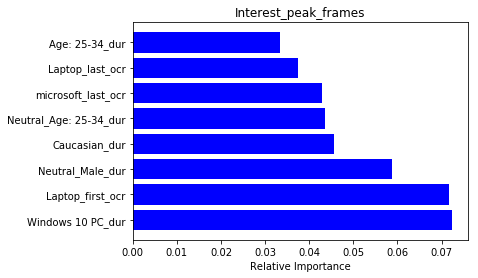

In [22]:
model.plot_feature_importance(models_4,10,y_train_4.columns,X_train_4.columns[1:],savefig=False)

In [59]:
shap.initjs()
explainer=[]
shap_values=[]
for i in range(4):
    explainer.append(shap.TreeExplainer(models_4[i]))
    shap_values.append(explainer[-1].shap_values(X_train_4.drop('Video Name',1)))
    print(i)

0
1
2
3


In [2]:
shap.summary_plot(shap_values[3],X_train_14.drop('Video Name',1))

NameError: name 'shap' is not defined

In [60]:
X_train_14.to_excel('../../Version_1.01/x_train_14.xlsx')

In [61]:
X_test_14.to_excel('../../Version_1.01/x_test_14.xlsx')
y_train_14.to_excel('../../Version_1.01/y_train_14.xlsx')
y_test_14.to_excel('../../Version_1.01/y_test_14.xlsx')

In [62]:
X_train_4.to_excel('../../Version_1.01/x_train_4.xlsx')
X_test_4.to_excel('../../Version_1.01/x_test_4.xlsx')
y_train_4.to_excel('../../Version_1.01/y_train_4.xlsx')
y_test_4.to_excel('../../Version_1.01/y_test_4.xlsx')